In [1]:
import pandas as pd
import numpy as np
import warnings

import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic

from tsplot import tsplot

warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Predikce množství přeháněk

Prvotně musíme analyzovat získaná data z měření a poté natrénovat model, abychom mohli predikovat vývoj. Data jsou stahovaná a upravovaná v souboru _data.ipynb_.

In [2]:
df = pd.read_csv('data/raingauges.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['rain'] = df['rain'].astype(float)
df = df.set_index('date')

## Analýza dat

Data jsou měřenná každý den, což většinou způsobuje velké nepříjmenosti v úloze predikce. Týdenní a měsíční průměrování je často pro tuto úlohu výhodné, protože nás dokáže zbavit anomálií a snížíme tak složitost modelu.

Koukneme se na vlastnosti ACF a PACF našich dat.

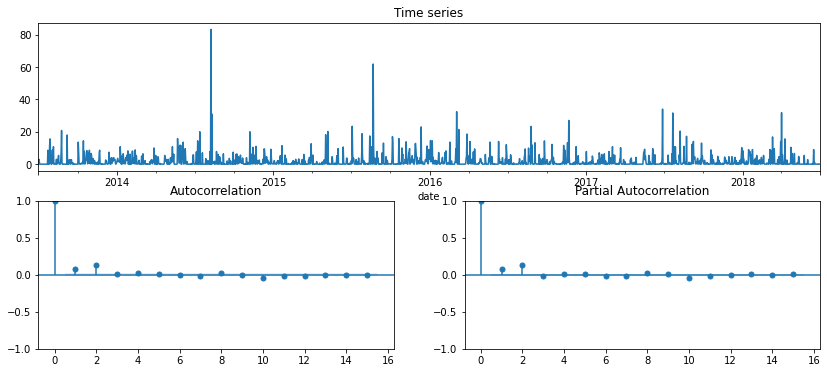

In [3]:
daily = df['rain'].asfreq('D')

tsplot(daily)

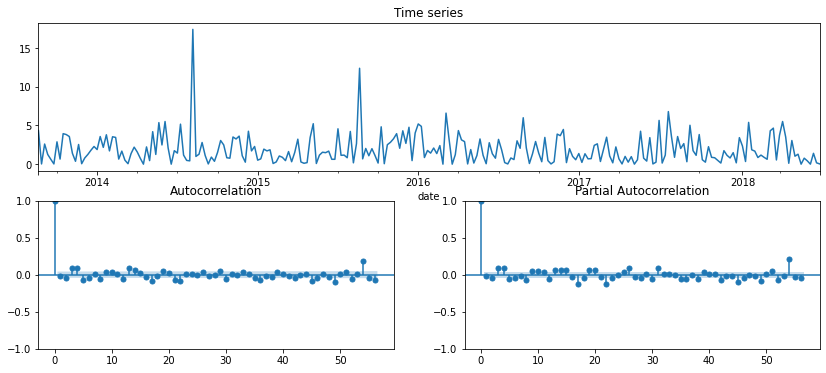

In [31]:
# převzorkování týdenní
weekly = daily.resample('W').mean()
weekly = weekly[7:]
tsplot(weekly, lags=56)

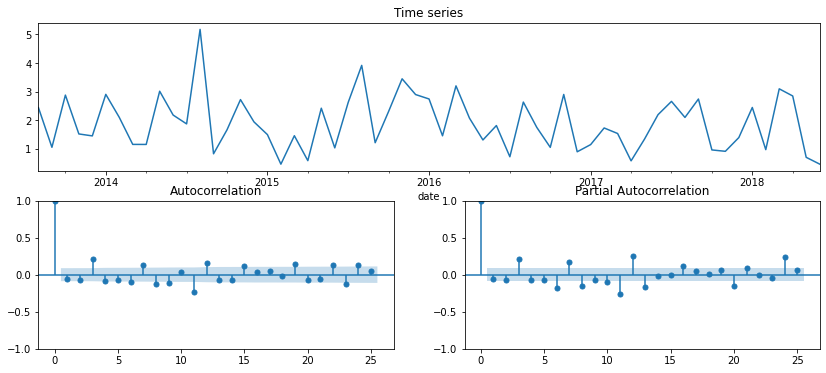

In [32]:
# převzorkování měsíční
monthly = daily.resample('M').mean()
monthly = monthly[1:]
tsplot(monthly, lags = 25)

Očividně nemáme výrazný trend, ale zdá se, že data pomalu klesají. Vypadá to, že máme náznak sezónnosti. Každopádně se zde nedá skoro nic poznat a právě proto použijeme ARIMA model.

Data nemají skoro žádnou výraznou autokorelaci. Je možné, že se jedná o šum.

Zkusíme udělat dekompozici dat a třeba nám to řekne víc.

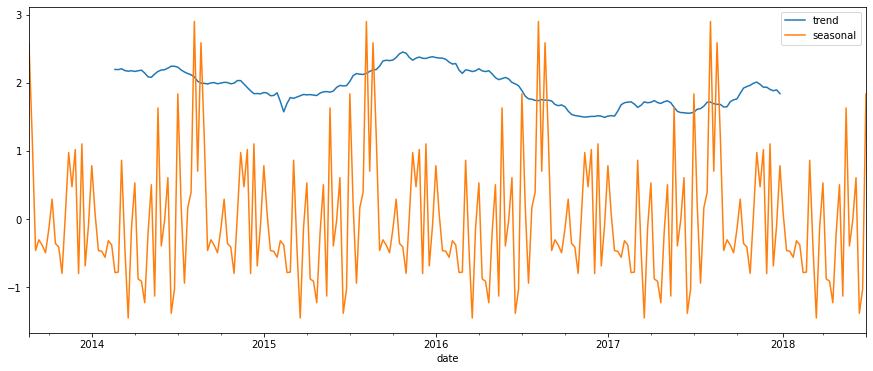

In [6]:
decomposition = seasonal_decompose(weekly, model='aditive')
decomposition.trend.plot(figsize = (15,6))
decomposition.seasonal.plot(figsize = (15,6))
plt.legend()

In [7]:
print("indices of peaks:")
i = 0
for val in decomposition.seasonal:
    i += 1
    if val > 2:
        print(i)

indices of peaks:
1
51
53
103
105
155
157
207
209


Trend se zdá trochu klesající, ale není nijak výrazný. Diferencování nebude pravděpodobně potřeba, ale stacionaritu radši ověříme dále. Sezónnost se zdá být roční lag(52) pro týdny, ale je zvláštní, že máme dvojitý peak.

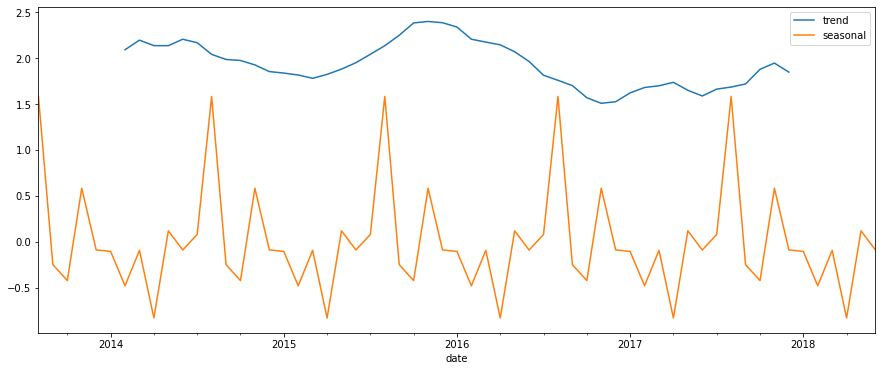

In [8]:
decomposition = seasonal_decompose(monthly, model='aditive')
decomposition.trend.plot(figsize = (15,6))
decomposition.seasonal.plot(figsize = (15,6))
plt.legend()

In [9]:
print("indices of peaks:")
i = 0
for val in decomposition.seasonal:
    i += 1
    if val > 1:
        print(i)

indices of peaks:
1
13
25
37
49


Z této dekompozice to opravdu vypadá, že trend klesá a je patrná roční sezónnost lag(12) pro měsíce.

## Statistické testy stacionarity

Z ACF a PACF je zřejmé, že trend není přítomný a v dekompozicích se zdá být nevýrazný, ale projistotu otestujeme stacionaritu.

In [10]:
adf = adfuller(weekly, autolag='BIC')
print(f"weekly\ntest statistic: {adf[0]}\np-value: {adf[1]}\np < alfa: {adf[1] < 0.05}\n")
adf = adfuller(monthly, autolag='BIC')
print(f"monthly\ntest statistic: {adf[0]}\np-value: {adf[1]}\np < alfa: {adf[1] < 0.05}")

weekly
test statistic: -16.17804386919142
p-value: 4.2953872325949574e-29
p < alfa: True

monthly
test statistic: -7.786146619348155
p-value: 8.169952727868146e-12
p < alfa: True


P-value je menší než hladina alfa a tudíž zamítáme hypotézu, že data jsou nestacionární.

## Dataset

In [11]:
train_w, test_w = weekly[:208], weekly[207:]
train_m, test_m = monthly[:48], monthly[47:]

print(f"weekly dataset\ntrain set: {len(train_w)}\ntest set: {len(test_w)}\n")
print(f"monthly dataset\ntrain set: {len(train_m)}\ntest set: {len(test_m)}")

weekly dataset
train set: 208
test set: 47

monthly dataset
train set: 48
test set: 12


# Model

## Selekce

Nalezneme nejlepší model dle AIC kritéria.

In [12]:
# týdenní model
model_w = pm.auto_arima(train_w, 
                        start_p=1, start_q=1, max_p=5, max_q=5, d=0,
                        start_P=1, start_Q=1, max_P=5, max_Q=5, D=1, m=52, 
                        seasonal=True, trace=True, information_criterion='aic', stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=746.810, Time=13.12 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=767.718, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=744.682, Time=3.76 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=5.27 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=766.281, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=769.062, Time=0.38 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=745.363, Time=9.71 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=745.361, Time=7.04 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=5.70 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=747.361, Time=10.35 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=743.198, Time=2.64 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=743.957, Time=7.01 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=743.957, Time=5.07 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(0,0,0)(2,1,1)[52] intercept   : AIC=

In [13]:
# měsíční model
model_m = pm.auto_arima(train_m, 
                        start_p=1, start_q=1, max_p=5, max_q=5, d=0,
                        start_P=1, start_Q=1, max_P=5, max_Q=5, D=1, m=12,
                        seasonal=True, trace=True, information_criterion='aic', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=120.649, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=115.306, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=118.851, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=120.975, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=113.969, Time=0.22 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=117.805, Time=1.78 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=112.047, Time=0.14 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=113.786, Time=0.05 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=114.047, Time=0.26 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=114.047, T

## Trénování

Modely si vytvořím pomocí _ARIMA()_ ze _statsmodels_.

### Týdenní

In [14]:
# model_w = SARIMAX(train_w, order=(0, 0, 0), seasonal_order=(0, 0, 1, 15), trend='c').fit()

model_w = ARIMA(train_w, order=(0, 0, 0), seasonal_order=(1, 1, 0, 52)).fit()
print(model_w.summary())

                               SARIMAX Results                                
Dep. Variable:                   rain   No. Observations:                  208
Model:             ARIMA(1, 1, 0, 52)   Log Likelihood                -368.646
Date:                Sat, 17 Dec 2022   AIC                            741.292
Time:                        13:35:25   BIC                            747.391
Sample:                    08-25-2013   HQIC                           743.769
                         - 08-13-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.4972      0.032    -15.369      0.000      -0.561      -0.434
sigma2         6.0117      0.328     18.331      0.000       5.369       6.654
Ljung-Box (L1) (Q):                   0.56   Jarque-

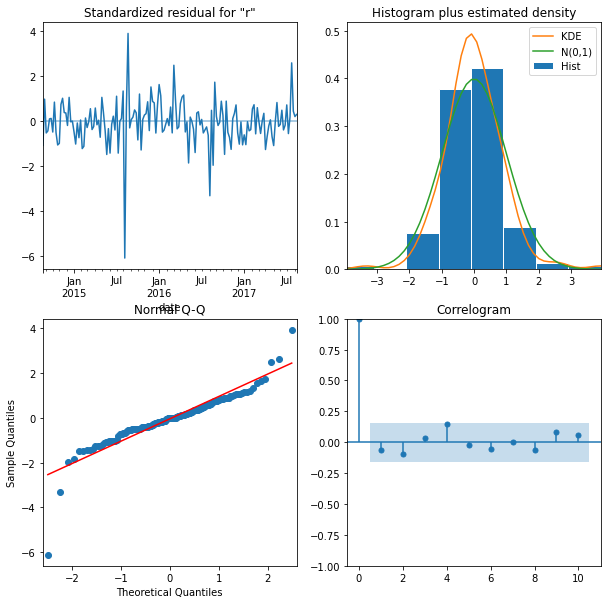

In [15]:
model_w.plot_diagnostics(figsize=(10,10))
plt.show()

Z výsledků pro týdenní model plyne:

**Ljung-Box** \
Nezamítám hypotézu, že data jsou nekorelovaná. 

**Heteroskedasticita** \
Zamítám hypotézu o tom, že rezidua nejsou heteroskedastická.

**Jarque-Bera** \
Zamítám hypotézu o tom, že rezidua mají šikmost a špičatost stejné jako normální rozdělení.

Ze standardizovaných reziduí to nevypadá, že by tam bylo něco přímočarého, co by se dalo vyčíst z dat, ale korelogram ukazuje, že tam ještě závislost je. Pravděpodobně to bude spojené s tím, že ta sezónnost má vrcholky blízko sebe a tudíž nepřesně diferencuji.


### Měsíční

In [16]:
# model_m = SARIMAX(train_m, order=(1, 0, 0), seasonal_order=(2, 1, 1, 13), trend='c').fit(n_periods=50)
# model_m = ARIMA(train_m, order=(0, 0, 0), seasonal_order=(2, 1, 0, 12)).fit()
# model_m = ARIMA(train_m, order=(1, 0, 0), seasonal_order=(0, 1, 0, 12)).fit()

model_m = ARIMA(train_m, order=(0, 0, 0), seasonal_order=(2, 1, 0, 12)).fit()
print(model_m.summary())

                               SARIMAX Results                                
Dep. Variable:                   rain   No. Observations:                   48
Model:             ARIMA(2, 1, 0, 12)   Log Likelihood                 -52.125
Date:                Sat, 17 Dec 2022   AIC                            110.249
Time:                        13:35:26   BIC                            115.000
Sample:                    08-31-2013   HQIC                           111.907
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8625      0.237     -3.636      0.000      -1.327      -0.398
ar.S.L24      -0.4920      0.203     -2.424      0.015      -0.890      -0.094
sigma2         0.7692      0.289      2.665      0.0

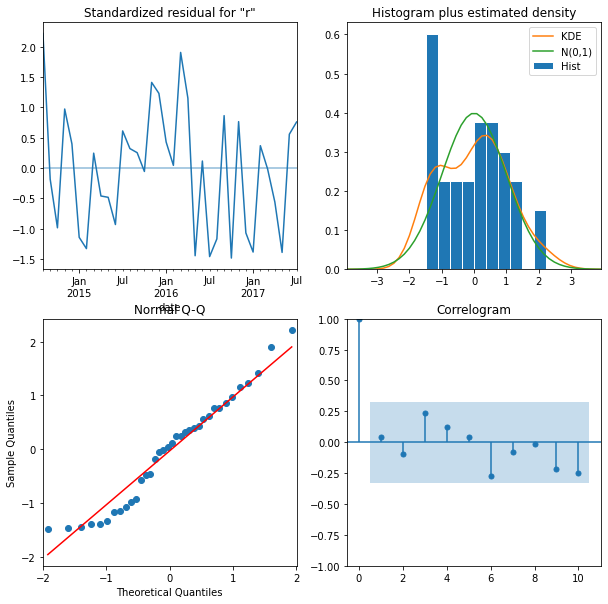

In [17]:
model_m.plot_diagnostics(figsize=(10,10))
plt.show()

Z výsledků pro měsíční model plyne:

**Ljung-Box** \
Nezamítám hypotézu, že data jsou nekorelovaná. 

**Heteroskedasticita** \
Neamítám hypotézu o tom, že rezidua nejsou heteroskedastická.

**Jarque-Bera** \
Nezamítám hypotézu o tom, že rezidua mají šikmost a špičatost stejné jako normální rozdělení.

Z reziduí nevypadá, že vypadne něco rozumného a autokorelace to potvrzuje. Samotné rozdělení je dost podobné normálnímu.

## Predikce

### Týdenní model

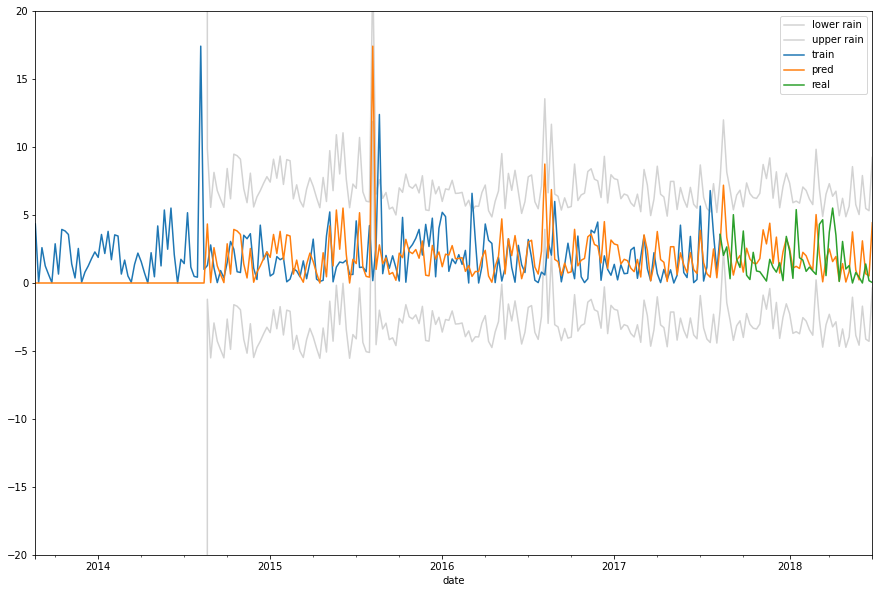

In [18]:
preds = model_w.get_prediction(end='2018-07-01')
ci = preds.conf_int()
fig = ci.plot(color='lightgrey', figsize=(10, 5))
model_w.data.orig_endog.plot(label='train', fig=fig, figsize=(15, 10))
preds.predicted_mean.plot(label='pred', fig=fig)
test_w.plot(label='real', fig=fig)
plt.legend()
plt.ylim(-20, 20)
plt.show()

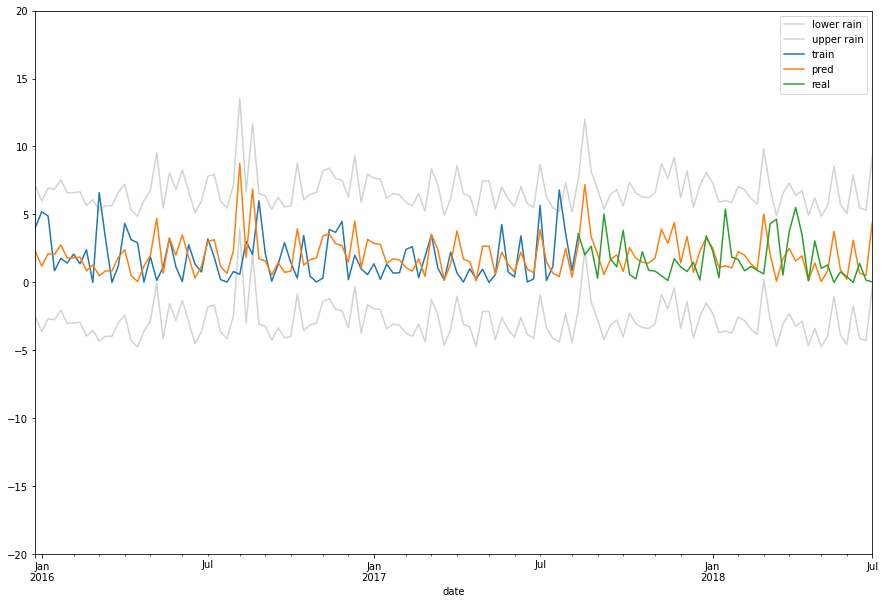

In [19]:
fig = ci.plot(color='lightgrey', figsize=(10, 5))
model_w.data.orig_endog.plot(label='train', fig=fig, figsize=(15, 10))
preds.predicted_mean.plot(label='pred', fig=fig)
test_w.plot(label='real', fig=fig)
plt.legend()
plt.xlim(2400)
plt.ylim(-20, 20)
plt.show()

In [20]:
print(f'MAE = {model_w.mae:.4f}')
print(f'MSE = {model_w.mse:.4f}')

MAE = 1.8565
MSE = 8.0342


### Měsíční model

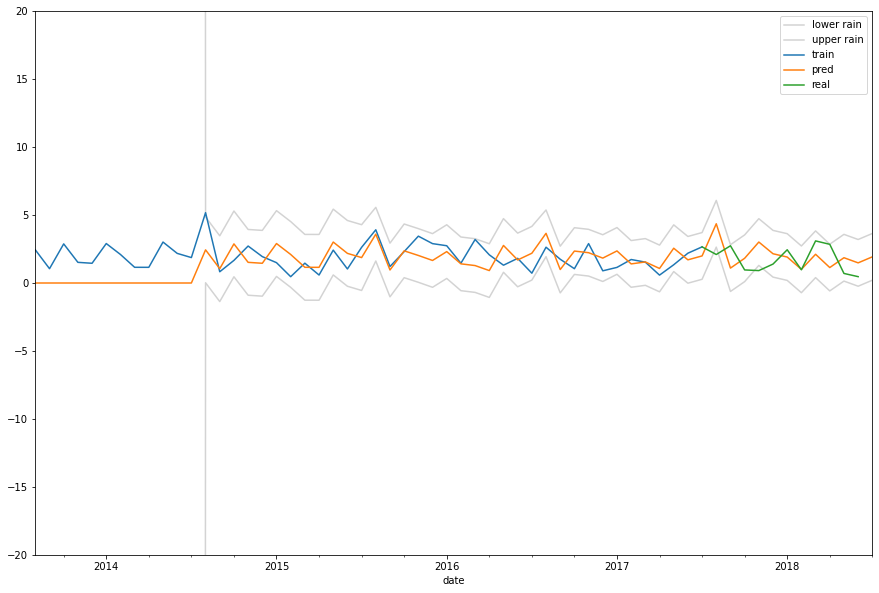

In [21]:
preds = model_m.get_prediction(end='2018-07-01')
ci = preds.conf_int()
fig = ci.plot(color='lightgrey', figsize=(10, 5))
model_m.data.orig_endog.plot(label='train', fig=fig, figsize=(15, 10))
preds.predicted_mean.plot(label='pred', fig=fig)
test_m.plot(label='real', fig=fig)
plt.legend()
plt.ylim(-20, 20)
plt.show()

In [22]:
print(f'MAE = {model_m.mae:.4f}')
print(f'MSE = {model_m.mse:.4f}')

MAE = 1.1451
MSE = 1.9247


# Závěr

Nevím, zda jsem něco nedělal zle, ale když jsem experimentoval s modely a protože si stále nejsem jistý sezónností (přeci jen se zdá, že se posouvá a není v hodnotách ACF/PACF výrazně významná), tak když jsem jí nezahrnul a spustil jsem _auto\_arima_, tak mi vracel ARIMA(0, 0, 0) s průměrem reziduí blízko nuly. Nepotvrzuje to právě mou prvotní teorii o tom, že data můžou být bílý nebo podobný šum?

Experimentoval jsem i s omezením množství dat na 1, 2 a 3 roky s průměrováním vzorků i bez a výsledek byl vždy stejný. Funkce doporučuje model ARIMA(0, 0, 0), rezidua vypadají, že z nich nic nejde vykoukat a Ljung-Box test říká, že tam nic není.